# Refine

Using the first set of annotations, train a model, and use this to sample a second round of annotations that will be more informative than random for the model.

In [1]:
%cd ..

/home/bookfinder


In [2]:
import numpy as np
import pandas as pd

from datasets import Dataset

from sentence_transformers.losses import CosineSimilarityLoss

from setfit import SetFitModel, SetFitTrainer

# Train the model

## Read in existing annotations

In [3]:
df_in = pd.read_json('data/00_annotations/03_book_binary/hnbook_classify.jsonl', lines=True)

In [4]:
counts = df_in.answer.value_counts()
counts

reject    86
accept    11
ignore     3
Name: answer, dtype: int64

## Stratified Sample

Create a 1:1 sample of reject and accept

In [5]:
n_sample = counts.loc[['reject', 'accept']].min()

n_sample

11

In [6]:
df_train = (
    df_in
    .query('answer != "ignore"')
    .groupby('answer', group_keys=False)
    .apply(lambda x: x.sample(min(len(x), n_sample)))
)

df_train.answer.value_counts()

accept    11
reject    11
Name: answer, dtype: int64

## Train the model

We'll use [SetFit](https://huggingface.co/blog/setfit) which is fast and good for few-shot text classification like this.

In [7]:
train_dataset = Dataset.from_pandas(df_train)
train_dataset

Dataset({
    features: ['text', 'meta', '_input_hash', '_task_hash', 'label', '_view_id', 'answer', '_timestamp', '__index_level_0__'],
    num_rows: 22
})

Use `all-MiniLM-L6-v2` which is very fast, while still quite accurate (based on the SentenceTransformers [benchmarks](https://www.sbert.net/docs/pretrained_models.html)).

In [8]:
model = SetFitModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


We'll leave all these as their default

In [9]:
trainer = SetFitTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=None,
    loss_class=CosineSimilarityLoss,
    metric="accuracy",
    batch_size=16,
    num_iterations=20, # The number of text pairs to generate for contrastive learning
    num_epochs=1, # The number of epochs to use for constrastive learning
    column_mapping={"text": "text", "answer": "label"} # Map dataset columns to text/label expected by trainer

)

In [10]:
trainer.train()

Applying column mapping to training dataset
***** Running training *****
  Num examples = 880
  Num epochs = 1
  Total optimization steps = 55
  Total train batch size = 16


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/55 [00:00<?, ?it/s]

In [11]:
model.save_pretrained('data/06_models/setfit_0')

# Predict

Now let's perform inference with our trained model on our data to annotate.

In [12]:
df = (
    pd.read_parquet('data/02_intermediate/hn_enriched.parquet')
    .query('bucket<3 & text_length > 0')
)

In [13]:
text = df.clean_text.to_list()

Get the column corresponding to 'accept'

In [14]:
model.model_head.classes_

array(['accept', 'reject'], dtype='<U6')

In [15]:
accept_idx = list(model.model_head.classes_).index('accept')
accept_idx

0

Calculate the accept probabilities

In [16]:
%%time
probs = model.predict_proba(text)[:,accept_idx]

CPU times: user 2min 8s, sys: 7.69 s, total: 2min 16s
Wall time: 1min 20s


In [17]:
df['prob'] = probs

## Check the results

In [18]:
pd.options.display.max_colwidth = 1000

It works pretty well!

In [19]:
df.sort_values('prob', ascending=False)[['clean_text']][:10]

,clean_text
id,
29315400,I was introduced to the concept by this book:\n\nhttps://www.amazon.com/Corporations-Examples-Explanations-Alan-Palmiter/dp/1454802472\n\nBut it’s probably a lot more than you bargained for.
29022116,"Second this, Becoming Steve Jobs is the superior book. It helped a lot that the authors had interacted with Jobs over decades and also had an understanding of business and technology that Isaacson was missing.\n\nThere’s also an old documentary about the founding of NeXT that does such a great job of showing what it was like to be in the room with him as a member of a small team, and this was before he fully “became” Steve Jobs. People underestimate how much meaning can be found in being pushed hard by someone with a clear and inspiring vision.\n\nhttps://m.youtube.com/watch?v=Udi0rk3jZYM"
27225900,"That's a great one! Also available at SE as ""Memoirs of a Madman"": https://standardebooks.org/ebooks/nikolai-gogol/short-fiction/claud-field_isabel-f-hapgood_vizetelly-and-company_george-tolstoy"
28902849,"I can’t tell you what is that website, but the concept of broken window reminds me a book that talked about it:\n\nhttps://www.amazon.fr/Pragmatic-Programmer-Journeyman-Master/dp/020161622X\n\n(No affiliation)"
27386353,A related great read is the book Into the Cool[1]. Highly recommend.\n\n[1] https://press.uchicago.edu/ucp/books/book/chicago/I/bo3533936.html
26902721,The Secrets of Consulting[1][2] sounds like a book you might appreciate in your current situation.\n\n[1] https://www.amazon.com/Secrets-Consulting-Giving-Getting-Successfully/dp/0932633013\n\n[2] https://www.goodreads.com/book/show/566213.The_Secrets_of_Consulting
28074710,"Looking forward to grabbing a physical copy of this book. As a beginner, CI and Alex Aiken’s course at Stanford were a great place to start.\n\nBob also gave me a lot of insight on what it’s like working on programming languages in the industry when I reached out to him as an undergrad."
26726081,"I hope you like this biography on Paul Erdos. Great read. If you like it recommend it to others. I have gifted it to many friends and even to those who are not mathematicians, STEMmy or mathematically inclined. Hope you get a chance to read it.\n\nhttps://en.wikipedia.org/wiki/The_Man_Who_Loved_Only_Numbers"
25723649,"> I'm really not sure who your target audience is, though.\n\nWe should ask Havoc Pennington about this, he must have names for all the personas that he came up with, after reading ""The Inmates Are Running the Asylum"": https://mail.gnome.org/archives/desktop-devel-list/2002-December/msg00482.html\n\nI actually have a copy of the book, and it is indeed a good book. The problem is that it somehow empowers GNOME developers to keep creating/maintaining/rewriting broken software, all in the name of ""usability""."


# Stratified sample for annotation.

We want to get some interesting examples to annotate.

If we pick at random, most won't have titles of books or works of art.
Instead sample equally from each decile to get a mixture of positives, negatives and borderline cases.

<AxesSubplot: >

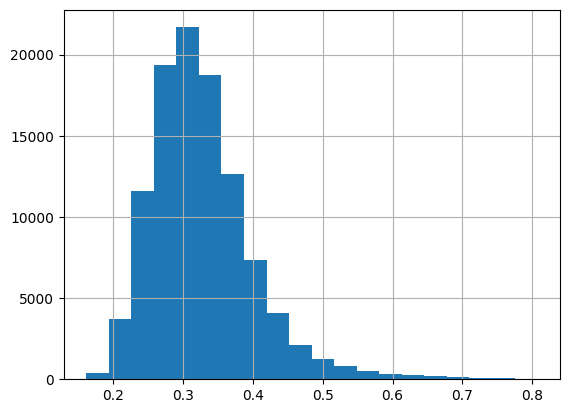

In [20]:
df['prob'].hist(bins=20)

In [21]:
df['bucket'] = (df['prob']*10).astype(int)

In [22]:
n_sample = 20

Remove the items that are already annotated

In [23]:
annotated_ids = [x['id'] for x in df_in['meta'].to_list()]

In [24]:
df_out = (
    df.loc[~df.index.isin(annotated_ids)]
    .groupby('bucket', group_keys=False)
    .apply(lambda x: x.sample(min(len(x), n_sample)))
    .sample(frac=1)
)

In [25]:
len(df_out)

140

In [26]:
df_out.bucket.value_counts()

6    20
4    20
3    20
1    20
5    20
2    20
7    20
Name: bucket, dtype: int64

Save to JSON

In [27]:
import json

with open('data/02_intermediate/hn_sample_1.jsonl', 'w') as f:
    for id, row in df_out.iterrows():
        data = {"text": row["clean_text"], "meta": {"id": id}}
        print(json.dumps(data), file=f)